# Visualizing the SALTED tutorial

Paraphrases:
- descriptor == atomic environment
- Resolution of Identity (RI) == density fitting
- symmetry-adapted == lambda-adapted, because $\lambda$ refers to azimuthal numbers

Tips:
- If long cell output encountered, you can right click and then choose `Enable scrolling output`.


Let's first do some preparations!

In [1]:
import os

import h5py
import matplotlib.pyplot as plt
import numpy as np
import py3Dmol
import salted
from ase.visualize import view as ase_view
from ase.io import read
from ipywidgets import IntSlider, interact
from scipy import sparse
from scipy.stats import pearsonr
from sklearn.manifold import TSNE, trustworthiness
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
""" Trick: make use of OpenMP in notebooks """

_NUM_CPUS = "4"
os.environ["MKL_NUM_THREADS"] = _NUM_CPUS
os.environ["NUMEXPR_NUM_THREADS"] = _NUM_CPUS
os.environ["OMP_NUM_THREADS"] = _NUM_CPUS

In [3]:
""" Change directory, assume everyone starts jupyter from dir `solution-notebook` """

RUN_DIR = os.path.abspath("./tutorial-run")  # PLEASE change this if error occurs
assert os.path.exists(RUN_DIR), f"Run directory does not exist. Currently at {os.getcwd()}."
os.chdir(RUN_DIR)
print("Changed working directory to:", RUN_DIR)

Changed working directory to: /home/zekunlou/Projects/2505_CNPEM_inct-tutorial-2025/SALTED-tutorial/tutorial-run


In [4]:
""" Function to read xyz snapshots from a file and visualize them """

def read_xyz_snapshots(file_path):
    with open(file_path) as file:
        content = file.read()
    snapshots = content.strip().split("\n\n")  # Assuming each snapshot is separated by a blank line
    return snapshots


def read_xyz_snapshots_continuous(file_path):
    snapshots = []
    with open(file_path) as file:
        while True:
            header = file.readline()
            if not header:
                break  # End of file
            num_atoms = int(header.strip())
            comment = file.readline()  # Comment line, not used here but necessary to read

            # Read the atom lines for this snapshot
            atoms = [file.readline() for _ in range(num_atoms)]

            # Combine to form the snapshot
            snapshot = f"{num_atoms}\n{comment}{''.join(atoms)}"
            snapshots.append(snapshot)

    return snapshots


def visualize_snapshot(snapshots, index=0):
    view = py3Dmol.view(width=800, height=400)  # Adjust size as needed
    view.addModel(snapshots[index], "xyz")
    view.setStyle({"stick": {}})
    view.zoomTo()
    return view.show()


## Visualizing the training set

We will **visualize the training dataset** using `py3Dmol` or `ASE`.


In [ ]:
""" Visualize the test dataset structures using ase, use scrollbar to zoom in and out """

file_path = './water_monomers_100.xyz'
snapshots = read_xyz_snapshots_continuous(file_path)
slider = IntSlider(min=0, max=len(snapshots)-1, step=1, value=0, description='Snapshot Index', continuous_update=False)
interact(lambda index: visualize_snapshot(snapshots, index), index=slider)

In [ ]:
""" if interactive widget doesn't work, please run this cell """

file_path = './water_monomers_100.xyz'
slider = IntSlider(min=0, max=len(read(file_path, ":")), step=1, value=0, description='Snapshot Index', continuous_update=False)
interact(lambda index: ase_view(read(file_path, index), viewer='x3d'), index=slider)

**Note**: We will assume that the **data has already been generated** and proceed to analyse it and do the fitting procedure

## Density fitting (or RI) and its quality

In quantum chemistry calculations, the **electron density** $\rho(\vec{r})$ is a fundamental quantity.
The electron density is often expressed in terms of a **density matrix**, and for atomic orbital (AO) basis sets, the density matrix looks like this:
$$
\rho (\vec{r}) = \sum_{I \mu J \nu} \rho_{I \mu J \nu} \phi_{I \mu} (\vec{r}) \phi_{J \nu}^* (\vec{r})
$$
where $\rho_{I \mu J \nu}$ are density matrix elements and $\phi_{I \mu} (\vec{r})$ are AO basis functions, each consisting of a radial part and an angular part (spherical harmonics).

The **Resolution of Identity (RI, or density fitting)** method approximates the true SCF electron density using a set of auxiliary basis functions $Q_{Im}$:
$$
\rho^{\mathrm{RI}}(\vec{r}) = \sum_{Im} c_{Im} Q_{Im}(\vec{r})
\approx \rho^{\mathrm{SCF}}(\vec{r})
$$
Here, $c_{Im}$ are the RI coefficients and $Q_{Im}(\vec{r})$ are the auxiliary basis functions, each composed of radial and angular (spherical harmonics) components.
The RI coefficients $c_{Im}$ serve as learning targets for the SALTED model, and since these coefficients are expressed in the spherical harmonics basis, they naturally **rotate equivariantly** with molecular structure (so-called **tensorial properties**).

We assess RI quality using the mean absolute error **metric**:
$$
\delta = \frac{
    \int \mathrm{d} \vec{r} \left| \rho^{\mathrm{SCF}}(\vec{r}) - \rho^{\mathrm{RI}}(\vec{r}) \right|
}{
    \int \mathrm{d} \vec{r} \rho^{\mathrm{SCF}}(\vec{r})
}
$$


In [5]:
""" load and check the RI basis set information """

! python3 -m salted.get_basis_info

# print the basis data
salted_pkg_dir = os.path.dirname(salted.__file__)
! cat {salted_pkg_dir}/basis_data.yaml

basis_name='FHI-aims-clusters' already exists in /home/zekunlou/Projects/salted_install/SALTED/salted/basis_data.yaml
Basis data for duplicated species are the same (no conflicts). Write data union to file.
FHI-aims-clusters:
  H:
    lmax: 4
    nmax: [9, 7, 6, 3, 1]
  O:
    lmax: 5
    nmax: [9, 10, 9, 8, 6, 4]


In [6]:
""" get RI (density fitting) errors """
! python3 -m salted.aims.get_df_err

% MAE = 0.18799117512973673
time_cost = 6.23 s


We shall also check the distribution of the MAE values, and there is no outlier in the training set.

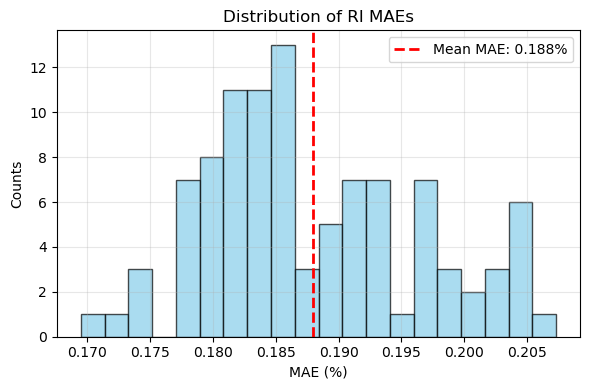

In [7]:
""" Load the MAE data for RI, and visualize it using histogram"""

data_df = np.loadtxt('df_maes')
data_df_y = data_df.T[1]

fig, ax = plt.subplots(figsize=(6, 4))
n, bins, patches = ax.hist(data_df_y, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
ax.axvline(x=np.mean(data_df_y), color='red', linestyle='--', linewidth=2, label=f'Mean MAE: {np.mean(data_df_y):.3f}%')

# Add title and labels
ax.set_title('Distribution of RI MAEs')
ax.set_xlabel('MAE (%)')
ax.set_ylabel('Counts')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Atomic environments and Visualization

![SOAP descriptor](./SOAP_illustration_with_kernel.png)


The SOAP descriptor (or atomic environment) is atom-centered, and its corresponding kernel function (the one for Gaussian process regression) is invariant to translation and rotation in real space.

The kernel function is constructed based on atomic density representation $\rho(\vec{r})$, while the atomic density representation is:
$$
\rho^{i,a} (\vec{r})
= \sum_j \delta_{a,a_j}
\exp \left( \dfrac{- |\vec{r} - \vec{r}_{ij}|^2}{2 \sigma_a^2} \right)
f_\mathrm{cut} (\vec{r}_{ij})
$$
where Gaussian functions are centered on each neighbouring atom $j$ of species $a$ within the cutoff radius.
So the central atom $i$ can see many fluffy Gaussian functions from its neighbours, and this is the atomic environment.


The invariant kernel function can be constructed from the atomic environment
$$
k(M_i, M_j) = \sum_{aa'} \int_{\hat{R} \in \mathrm{SO_3}} \mathrm{d} \hat{R}
\left| \int \mathrm{d} \vec{r} \rho^{i,a}(\vec{r}) \rho^{j,a'}(\hat{R}\vec{r}) \right|^2
$$
which has been widely used in learning invariant properties of materials by GPR.

Besides using the SOAP descriptor, SALTED has implemented several mathematical techniques to lift the efficiency boundary of traditional GPR methods.
Here we introduce the first two methods:

**Subset of Regressors (SoR)** approximates the full kernel matrix using only a representative subset $M$ of training points:
$$
K_{NN} \approx K_{NM} K_{MM}^{-1} K_{MN}
$$

This reduces the computational cost integrated with RKHS (see below). The subset $M$ is typically selected to capture the most important structural diversity in the training data.

**Farthest Point Sampling (FPS)** is a method used to select a subset of points from a larger set such that the selected points are as far apart from each other as possible.
This is particularly useful in scenarios where we want to ensure that the selected points represent the diversity of the original dataset.
In SALTED we select the subset $M$ based on powerspectrum, a intermediate representation of the atomic environment.


In [8]:
""" initialize salted and compute atomic environments """

! python3 -m salted.initialize  # output file: equirepr_test/FEAT-0.h5

time =  0.015987634658813477


In [9]:
""" sparsify the atomic environments based on the number `Menv` by FPS for SoR"""

! python3 -m salted.sparse_selection  # output file: equirepr_test/sparse_set_80.txt

Doing  1  of  80  dist =  1.9699382680256425
Doing  2  of  80  dist =  0.4055503277643395
Doing  3  of  80  dist =  0.17419203482769396
Doing  4  of  80  dist =  0.1664597934327665
Doing  5  of  80  dist =  0.16161840927108106
Doing  6  of  80  dist =  0.127513261278833
Doing  7  of  80  dist =  0.0757331379150572
Doing  8  of  80  dist =  0.07551821951434734
Doing  9  of  80  dist =  0.07025228151165241
Doing  10  of  80  dist =  0.06914437772906767
Doing  11  of  80  dist =  0.06833095880207418
Doing  12  of  80  dist =  0.055366148210852284
Doing  13  of  80  dist =  0.0535573957349087
Doing  14  of  80  dist =  0.051573035272990175
Doing  15  of  80  dist =  0.04234078873876146
Doing  16  of  80  dist =  0.03808160019133777
Doing  17  of  80  dist =  0.027261110519767984
Doing  18  of  80  dist =  0.026287958978675974
Doing  19  of  80  dist =  0.0250440664447229
Doing  20  of  80  dist =  0.02461567086405969
Doing  21  of  80  dist =  0.024553464869409236
Doing  22  of  80  dist =

In [10]:
""" Load the descriptors for visualization """

file_path = 'equirepr_test/FEAT-0.h5'
# Read data
with h5py.File(file_path, 'r') as file:
    datasoap = np.array(file['descriptor'])

n_samples, n_atoms, n_features = datasoap.shape
datasoap_reshaped = datasoap.reshape(n_samples * n_atoms, n_features)

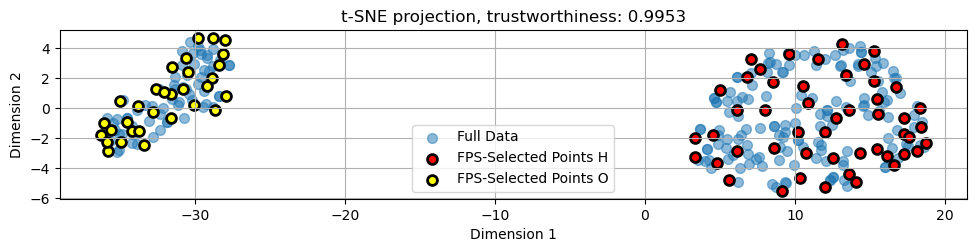

In [15]:
""" Visualize using t-SNE """

# Initialize t-SNE with desired parameters
tsne = TSNE(n_components=2, perplexity=50.0, max_iter=1000, random_state=42, n_jobs=-1)

# Apply t-SNE to the reshaped data (using the same reshaping as for PCA)
data_tsne = tsne.fit_transform(datasoap_reshaped)
data_trustworthiness = trustworthiness(datasoap_reshaped, data_tsne, n_neighbors=10)

# get indexes
fps_indices = (np.loadtxt("equirepr_test/sparse_set_80.txt")).T[0]
fps_species = (np.loadtxt("equirepr_test/sparse_set_80.txt")).T[1]
selected_indices_h = [int(i) for i, j in zip(fps_indices, fps_species) if j == 0]
selected_indices_o = [int(i) for i, j in zip(fps_indices, fps_species) if j == 1]

# Plot chosen points along with the original t-SNE projection
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(data_tsne[:, 0], data_tsne[:, 1], s=50, alpha=0.5, label="Full Data")
ax.scatter(
    data_tsne[selected_indices_h, 0],
    data_tsne[selected_indices_h, 1],
    color="red",
    edgecolor="k",
    label="FPS-Selected Points H",
    s=50,
    linewidths=2,
)
ax.scatter(
    data_tsne[selected_indices_o, 0],
    data_tsne[selected_indices_o, 1],
    color="yellow",
    edgecolor="k",
    label="FPS-Selected Points O",
    s=50,
    linewidths=2,
)

# Add labels and legend
ax.set_title("t-SNE projection, " + f"trustworthiness: {data_trustworthiness:.4f}")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_aspect('equal', adjustable='box')
ax.grid()
ax.legend()

plt.tight_layout()
plt.show()


## Computing the descriptors and symmetry-adapted kernels

Different from traditional SOAP descriptor, we use symmetry-adapted SOAP descriptor / kernels for tensorial properties prediction in SALTED.

The new symmetry-adapted kernel goes as
$$
\mathbf{k}^{\lambda} (M_i, M_j) = \int_{\hat{R} \in \mathrm{SO_3}} \mathrm{d} \hat{R} \mathbf{D}^{\lambda} (\hat{R})
\left| \int \mathrm{d} \vec{r} \rho^{i}(\vec{r}) \rho^{j}(\hat{R}^{-1} \vec{r}) \right|
$$
where $\mathbf{D}^{\lambda}$ is the Wigner D-matrix, which is a representation of the rotation group SO(3) in the spherical harmonics basis.

And continuing our mathematical techniques, the **SoR** integrates with **Reproducing Kernel Hilbert Space (RKHS)** facilitates efficient Gaussian process regression in SALTED.

With the SoR approximation above and the RKHS theory, the original kernel matrix $K_{NN}$ can be approximated as the inner product of RKHS feature vectors $\Psi_{ND}$:
$$
K_{NN} \approx K_{NM} K_{MM}^{-1} K_{MN} \approx \Psi_{ND} \Psi_{ND}^T
$$

The SALTED prediction then becomes:
$$
c_N \approx \Psi_{ND} \tilde{w}_D
$$
where $\tilde{w}_D$ are the learned feature weights, and the dimension $D$ (correlated to the number of selected atoms in FPS) is several orders of magnitude smaller than the original number of training points $N$.
SoR + RKHS here dramatically reduces both memory requirements and computational complexity.


Still, we have two steps to construct the symmetry-adapted quantities for GPR regression:
1. Compute the SoR central matrix $K_{MM}$, which contains those selected atomic environments.
2. Compute the RKHS feature vector $\Psi_{ND}$ for each training point $N$.

In [16]:
""" Compute SALTED symmetry-adapted descriptors for the selected sparse set of atomic environments """

! python3 -m salted.sparse_descriptor  # output file: equirepr_test/FEAT_M-80.h5

conf: 1
conf: 2
conf: 3
conf: 4
conf: 5
conf: 6
conf: 7
conf: 8
conf: 9
conf: 10
conf: 11
conf: 12
conf: 13
conf: 14
conf: 15
conf: 16
conf: 17
conf: 18
conf: 19
conf: 20
conf: 21
conf: 22
conf: 23
conf: 24
conf: 25
conf: 26
conf: 27
conf: 28
conf: 29
conf: 30
conf: 31
conf: 32
conf: 33
conf: 34
conf: 35
conf: 36
conf: 37
conf: 38
conf: 39
conf: 40
conf: 41
conf: 42
conf: 43
conf: 44
conf: 45
conf: 46
conf: 47
conf: 48
conf: 49
conf: 50
conf: 51
conf: 52
conf: 53
conf: 54
conf: 55
conf: 56
conf: 57
conf: 58
conf: 59
conf: 60
conf: 61
conf: 62
conf: 63
conf: 64
conf: 65
conf: 66
conf: 67
conf: 68
conf: 69
conf: 70
conf: 71
conf: 72
conf: 73
conf: 74
conf: 75
conf: 76
conf: 77
conf: 78
conf: 79
conf: 80
conf: 81
conf: 82
conf: 83
conf: 84
conf: 85
conf: 86
conf: 87
conf: 88
conf: 89
conf: 90
conf: 91
conf: 92
conf: 93
conf: 94
conf: 95
conf: 96
conf: 97
conf: 98
conf: 99
conf: 100


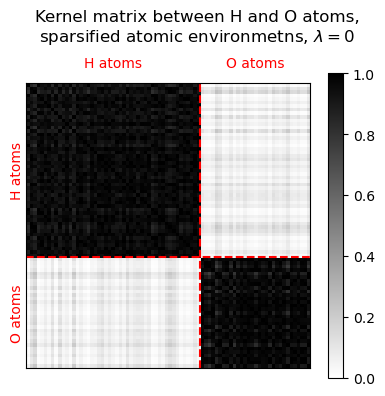

In [17]:
""" compute the kernel matrix of those selected sparse set of atomic environments """

with h5py.File("equirepr_test/FEAT_M-80.h5") as f:
    data_H0 = f['sparse_descriptors/H/0'][:]
    data_O0 = f['sparse_descriptors/O/0'][:]

data_H_and_O = np.concatenate((data_H0, data_O0), axis=0)
data_H_and_O_kernel = data_H_and_O @ data_H_and_O.T
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
im = ax.imshow(data_H_and_O_kernel, cmap='grey_r', vmin=0, vmax=1)
cbar = fig.colorbar(im, ax=ax)
fig.suptitle("Kernel matrix between H and O atoms,\n" + "sparsified atomic environmetns, $\lambda=0$")
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
ax.axvline(x=48.5, color='red', linestyle='--')
ax.axhline(y=48.5, color='red', linestyle='--')
ax.text(24, -5, "H atoms", color='red', ha='center')
ax.text(64, -5, "O atoms", color='red', ha='center')
ax.text(-5, 24, "H atoms", color='red', va='center', rotation='vertical')
ax.text(-5, 64, "O atoms", color='red', va='center', rotation='vertical')
fig.tight_layout()
plt.show()

In [18]:
""" Calculate RKHS feature vectors """

!python3 -m salted.rkhs_projector
!python3 -m salted.rkhs_vector

problem dimensionality: 7117
0 start
0 end, time cost = 0.06 s
1 start
1 end, time cost = 0.05 s
2 start
2 end, time cost = 0.05 s
3 start
3 end, time cost = 0.05 s
4 start
4 end, time cost = 0.05 s
5 start
5 end, time cost = 0.05 s
6 start
6 end, time cost = 0.05 s
7 start
7 end, time cost = 0.05 s
8 start
8 end, time cost = 0.05 s
9 start
9 end, time cost = 0.05 s
10 start
10 end, time cost = 0.05 s
11 start
11 end, time cost = 0.05 s
12 start
12 end, time cost = 0.06 s
13 start
13 end, time cost = 0.05 s
14 start
14 end, time cost = 0.05 s
15 start
15 end, time cost = 0.05 s
16 start
16 end, time cost = 0.05 s
17 start
17 end, time cost = 0.05 s
18 start
18 end, time cost = 0.06 s
19 start
19 end, time cost = 0.06 s
20 start
20 end, time cost = 0.05 s
21 start
21 end, time cost = 0.05 s
22 start
22 end, time cost = 0.05 s
23 start
23 end, time cost = 0.05 s
24 start
24 end, time cost = 0.05 s
25 start
25 end, time cost = 0.05 s
26 start
26 end, time cost = 0.05 s
27 start
27 end, ti

We can indeed reproduce the kernels after using RKHS and SoR.

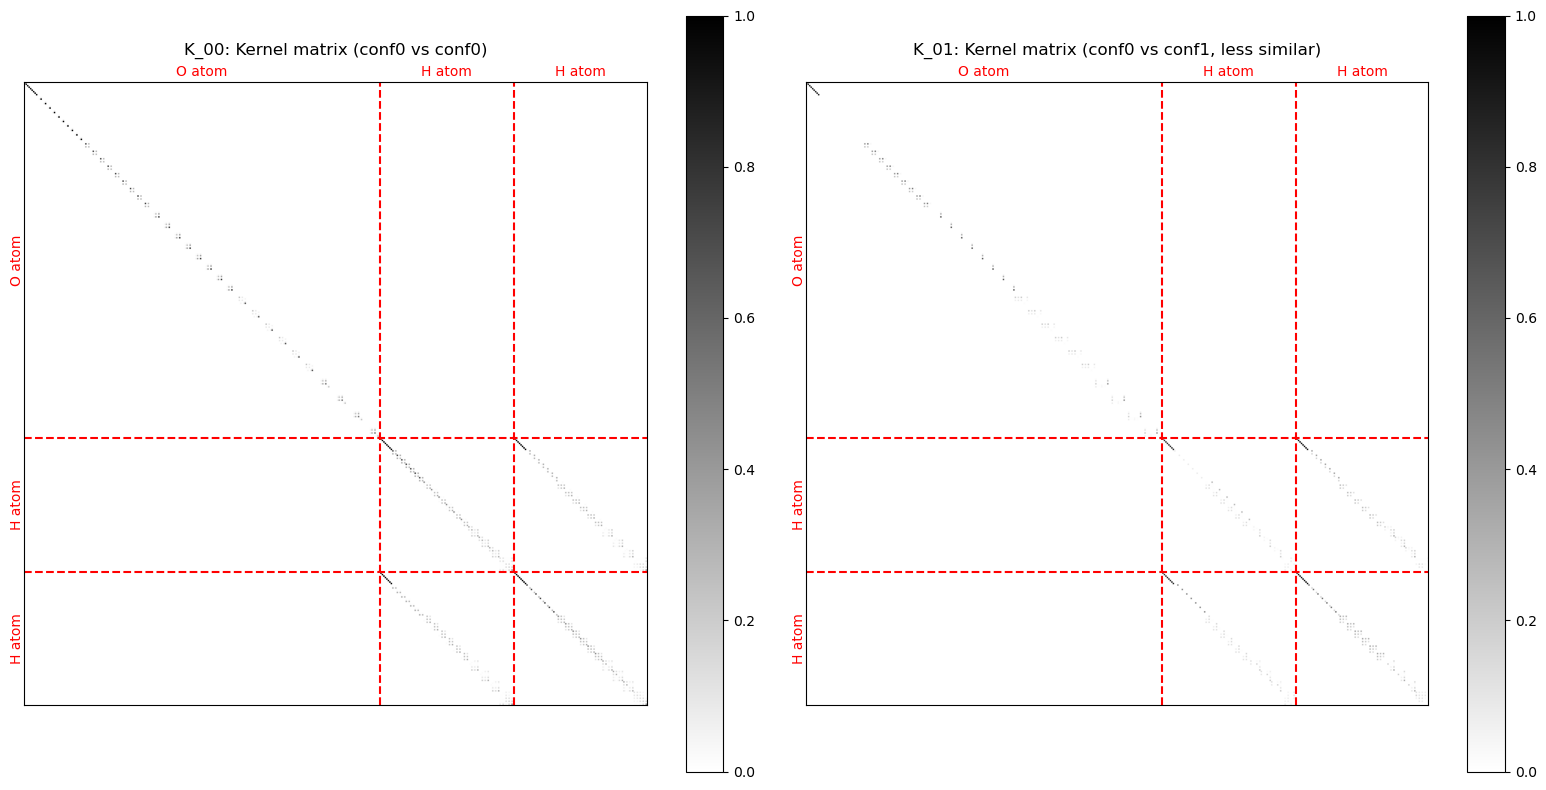

In [19]:
""" Visualize the symmetry-adapted kernel matrices K_00 and K_01 """

# Load RKHS vectors for different configurations
data_psi_0 = sparse.load_npz("rkhs-vectors_test/M80_zeta2.0/psi-nm_conf0.npz")
data_psi_1 = sparse.load_npz("rkhs-vectors_test/M80_zeta2.0/psi-nm_conf1.npz")

# Compute kernel matrices
kernel_mat_00 = sparse.csr_matrix.dot(data_psi_0, data_psi_0.T).toarray()  # K_00
kernel_mat_01 = sparse.csr_matrix.dot(data_psi_0, data_psi_1.T).toarray()  # K_01

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot K_00
im1 = axes[0].imshow(kernel_mat_00, cmap='grey_r', vmin=0, vmax=1)
axes[0].set_title("K_00: Kernel matrix (conf0 vs conf0)\n")
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].axhline(y=238.5, color='red', linestyle='--')
axes[0].axhline(y=328.5, color='red', linestyle='--')
axes[0].axvline(x=238.5, color='red', linestyle='--')
axes[0].axvline(x=328.5, color='red', linestyle='--')

# Plot K_01
im2 = axes[1].imshow(kernel_mat_01, cmap='grey_r', vmin=0, vmax=1)
axes[1].set_title("K_01: Kernel matrix (conf0 vs conf1, less similar)\n")
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].axhline(y=238.5, color='red', linestyle='--')
axes[1].axhline(y=328.5, color='red', linestyle='--')
axes[1].axvline(x=238.5, color='red', linestyle='--')
axes[1].axvline(x=328.5, color='red', linestyle='--')

# Add colorbars
cbar1 = fig.colorbar(im1, ax=axes[0])
cbar2 = fig.colorbar(im2, ax=axes[1])

# Add labels for atom types
for ax in axes:
    ax.text(119, -5, "O atom", color='red', ha='center')
    ax.text(283, -5, "H atom", color='red', ha='center')
    ax.text(373, -5, "H atom", color='red', ha='center')
    ax.text(-10, 119, "O atom", color='red', va='center', rotation='vertical')
    ax.text(-10, 283, "H atom", color='red', va='center', rotation='vertical')
    ax.text(-10, 373, "H atom", color='red', va='center', rotation='vertical')

plt.tight_layout()
plt.show()


## Regression in two ways

SALTED minimizes spatial density MSE (equivalently a weighted L2 loss) between predicted RI coefficients $\rho^\mathrm{ML}$ and target RI coefficients $\rho^\mathrm{RI}$:
$$
\begin{aligned}
\mathcal{L}(\tilde{w}_D)
& = \int \mathrm{d} \vec{r} (\rho^\mathrm{ML} - \rho^\mathrm{RI})^2 + L_2 (\tilde{w}_D) \\
& = (\Psi_{ND} \tilde{w}_D - c_N^{\mathrm{RI}})^T S_{NN} (\Psi_{ND} \tilde{w}_D - c_N^{\mathrm{RI}}) + \eta \tilde{w}_D^T \tilde{w}_D
\end{aligned}
$$

The overlap matrix $S_{NN}$ weights the loss in the auxiliary basis space, while $\eta$ provides L2 regularization.


**Direct Inversion Method**

Taking the derivative and setting it to zero gives the normal equations
$$
\begin{aligned}
(\Psi_{ND}^T S_{NN} \Psi_{ND} + \eta \mathbb{I}_{DD}) \tilde{w}_D
& - \Psi_{ND}^T S_{NN} c_N^{\mathrm{RI}} = 0 \\
\Rightarrow (\mathbf{H} + \eta \mathbb{I}_{DD}) \tilde{w}_D
& - \vec{A} = 0
\end{aligned}
$$
where matrix $H = \Psi_{ND}^T S_{NN} \Psi_{ND}$ is the **Hessian matrix** (second derivative of the loss function), which is positive definite and symmetric.
The problem can be solved by directly inverting the Hessian, and the matrix size is $D \times D$.
This is feasible for small dimensions $D$ (e.g., $D < 10^{5}$).


**Conjugate Gradient (CG) Method**

For large feature dimensions $D$, directly inverting the Hessian becomes expensive. Instead, we can solve $H \tilde{w}_D = b$ iteratively using CG, which only requires matrix-vector products with $H$ rather than explicit inversion.


In [20]:
""" Calculation GPR regression by direct inversion method """

! python3 -m salted.hessian_matrix  # build the hessian matrix
! python3 -m salted.solve_regression  # do inversion and obtain weights
! cp regrdir_test/M80_zeta2.0/weights_N70_reg-6.npy regrdir_test/M80_zeta2.0/weights_N70_reg-6-INV.npy  # save weights for later use

computing averages...
Running in serial mode
problem dimensionality: 7117
computing regression matrices...
conf: 36
conf time = 0.49350690841674805
conf: 42
conf time = 0.29720306396484375
conf: 46
conf time = 0.31606078147888184
conf: 5
conf time = 0.29662370681762695
conf: 77
conf time = 0.29948949813842773
conf: 13
conf time = 0.29390883445739746
conf: 1
conf time = 0.2959098815917969
conf: 65
conf time = 0.2987053394317627
conf: 43
conf time = 0.29871654510498047
conf: 12
conf time = 0.2935800552368164
conf: 82
conf time = 0.2860996723175049
conf: 40
conf time = 0.29962968826293945
conf: 8
conf time = 0.29126906394958496
conf: 49
conf time = 0.2946629524230957
conf: 79
conf time = 0.3029816150665283
conf: 16
conf time = 0.29060792922973633
conf: 54
conf time = 0.30148911476135254
conf: 63
conf time = 0.28866147994995117
conf: 10
conf time = 0.29393506050109863
conf: 53
conf time = 0.29070425033569336
conf: 69
conf time = 0.29583144187927246
conf: 56
conf time = 0.3033769130706787
c

Alternatively, we can do the regression by the conjugate gradient method, when direct inversion is too expensive (i.e. matrix larger than $10^{5} \times 10^{5}$).

In [ ]:
""" Calculate GPR regression by CG method and record the loss function values """

# Now alternative regression by minimizing the loss function with conjugate gradient. We copy previous weights just to plot later
! python3 -m salted.minimize_loss | tee regrdir_test/M80_zeta2.0/weights_N70_reg-6-CG.log
! cp regrdir_test/M80_zeta2.0/weights_N70_reg-6.npy regrdir_test/M80_zeta2.0/weights_N70_reg-6-CG.npy

with open("regrdir_test/M80_zeta2.0/weights_N70_reg-6-CG.log") as file:
    # extract 'step' and 'loss'. line format: `step 2300, gradient norm: 3.171e-05, loss: 1.222e-0`
    lines = [[i.strip(' ,:') for i in l.split()] for l in file.readlines()]
    lines = [[float(l[1]), float(l[-1])] for l in lines if len(l) == 7]  # take the step and loss values
np.savetxt('cg-loss_new.csv', np.array(lines), delimiter=',', header='step,loss', comments='')

computing averages...
loading matrices...
problem dimensionality: 7117
minimizing...
step 50, gradient norm: 6.807e-03, loss: 2.079e-04
step 100, gradient norm: 3.651e-03, loss: 5.285e-05
step 150, gradient norm: 1.844e-03, loss: 2.561e-05
step 200, gradient norm: 1.644e-03, loss: 1.489e-05
step 250, gradient norm: 5.669e-04, loss: 1.008e-05
step 300, gradient norm: 5.686e-04, loss: 7.328e-06
step 350, gradient norm: 6.168e-04, loss: 5.548e-06
step 400, gradient norm: 3.217e-04, loss: 4.466e-06
step 450, gradient norm: 4.441e-04, loss: 3.743e-06
step 500, gradient norm: 3.973e-04, loss: 3.268e-06
step 550, gradient norm: 1.992e-04, loss: 2.902e-06
step 600, gradient norm: 2.142e-04, loss: 2.627e-06
step 650, gradient norm: 8.446e-05, loss: 2.388e-06
step 700, gradient norm: 1.118e-04, loss: 2.204e-06
step 750, gradient norm: 6.817e-05, loss: 2.059e-06
step 800, gradient norm: 1.446e-04, loss: 1.940e-06
step 850, gradient norm: 1.763e-04, loss: 1.849e-06
step 900, gradient norm: 5.629e-

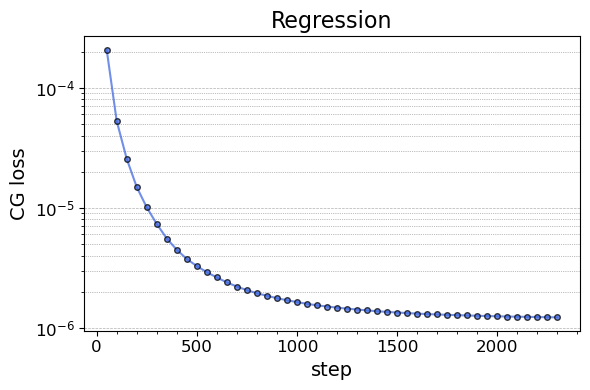

In [ ]:
""" check the behavior of descending loss in CG """

lossdata=np.loadtxt('./cg-loss_new.csv', delimiter=',', skiprows=1)
lossx=lossdata.T[0]
lossy=lossdata.T[1]

fig, ax = plt.subplots(figsize=(6, 4))

# Create a plot
ax.plot(lossx, lossy, marker='o', linestyle='-', color='royalblue', markersize=4, markeredgecolor='black', alpha=0.75)
ax.set_yscale('log')
ax.grid(which='both', axis='y', linestyle='--', linewidth=0.5)

ax.set_title('Regression', fontsize=16)
ax.set_xlabel('step', fontsize=14)
ax.set_ylabel('CG loss', fontsize=14)

# Optional: Customize the tick marks for better readability
ax.tick_params(axis='both', which='major', labelsize=12)

# Add a minor grid line for the log scale y-axis
ax.minorticks_on()
ax.grid(which='minor', axis='y', linestyle=':', linewidth='0.5', color='gray')

plt.tight_layout()
plt.show()


Weights obtained from direct inversion and CG are similar.

Relative RMSE between CG and INV weights: 0.169 %
Cosine similarity between CG and INV weights: 0.990295
Pearson correlation between CG and INV weights: 0.990305


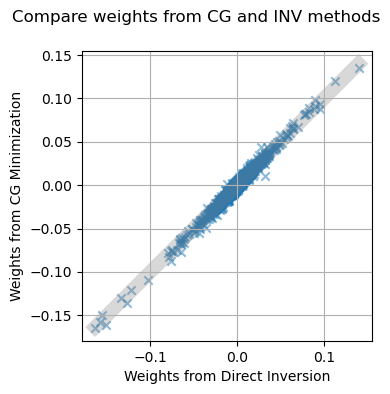

In [ ]:
""" compare weights from CG and INV methods by metrics and visualization """

weights_cg = np.load("regrdir_test/M80_zeta2.0/weights_N70_reg-6-CG.npy")
weights_inv = np.load("regrdir_test/M80_zeta2.0/weights_N70_reg-6-INV.npy")

rel_rmse = np.sqrt(np.mean((weights_cg - weights_inv) ** 2)) / np.linalg.norm((weights_cg + weights_inv) / 2)
cos_sim = cosine_similarity(weights_cg.reshape(1, -1), weights_inv.reshape(1, -1))[0][0]
pearson_corr, _ = pearsonr(weights_cg, weights_inv)
print(f"Relative RMSE between CG and INV weights: {100 * rel_rmse:.3f} %")
print(f"Cosine similarity between CG and INV weights: {cos_sim:.6f}")
print(f"Pearson correlation between CG and INV weights: {pearson_corr:.6f}")

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(weights_cg, weights_inv, alpha=0.5, marker="x")
ax.plot(
    [min(weights_cg), max(weights_cg)],
    [min(weights_cg), max(weights_cg)],
    color="grey",
    alpha=0.3,
    linewidth=10.0,
    zorder=1.0,
)
ax.set_xlabel("Weights from Direct Inversion")
ax.set_ylabel("Weights from CG Minimization")
ax.grid()
ax.set_aspect("equal")
fig.suptitle("Compare weights from CG and INV methods")
plt.tight_layout()
plt.show()


## Validation by electron density

To evaluate the spatial electron density prediction error, we implement electron density RMSE:
$$
\Delta\rho
= \left(
    \frac{
        \sum_k \int \mathrm{d} \vec{r} \left| \rho_k^\mathrm{ML}(\vec{r}) - \rho_k^\mathrm{RI}(\vec{r}) \right|^2
    }{
        \sum_k \int \mathrm{d} \vec{r} \left| \rho_k^\mathrm{RI}(\vec{r}) - \rho_k^\mathrm{sph}(\vec{r}) \right|^2
    }
\right)^{1/2}
= \left(
    \frac{
        \sum_k \left( c_k^\mathrm{ML} - c_k^{\mathrm{RI}} \right)^\top S_{k} \left( c_k^\mathrm{ML} - c_k^{\mathrm{RI}} \right)
    }{
        \sum_k \left( c_k^\mathrm{RI} - c_k^{\mathrm{sph}} \right)^\top S_{k} \left( c_k^\mathrm{RI} - c_k^{\mathrm{sph}} \right)
    }
\right)^{1/2}
$$
Notice that the denominator is spatial electron density subtracted by the spherical average, so this electron density RMSE metric is actually very sensitive to spatial prediction error.

In [21]:
""" Run validation on 30 structures not used in training """

! python3 -m salted.validation

2: 4.249e-01 % RMSE
9: 2.458e-01 % RMSE
17: 3.265e-01 % RMSE
20: 2.827e-01 % RMSE
21: 3.905e-01 % RMSE
25: 5.074e-01 % RMSE
30: 2.229e-01 % RMSE
31: 2.716e-01 % RMSE
34: 4.872e-01 % RMSE
48: 3.411e-01 % RMSE
50: 3.351e-01 % RMSE
51: 7.849e-01 % RMSE
61: 3.499e-01 % RMSE
67: 1.828e-01 % RMSE
70: 2.127e-01 % RMSE
71: 3.760e-01 % RMSE
75: 6.103e-01 % RMSE
76: 3.125e-01 % RMSE
78: 3.185e-01 % RMSE
81: 3.232e-01 % RMSE
83: 3.918e-01 % RMSE
85: 5.561e-01 % RMSE
86: 6.317e-01 % RMSE
88: 3.585e-01 % RMSE
89: 5.034e-01 % RMSE
90: 3.113e-01 % RMSE
91: 3.978e-01 % RMSE
94: 3.270e-01 % RMSE
95: 3.655e-01 % RMSE
98: 3.254e-01 % RMSE

 % RMSE: 4.007e-01


We shall further check each validation structure, if there are outliers and abnormally high errors, and the result is satisfactory.

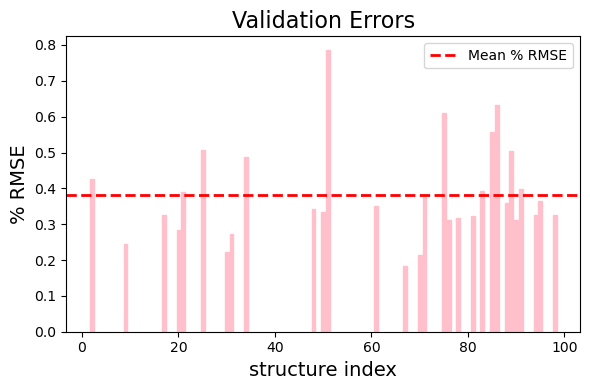

In [22]:
""" Load validation errors and visualize them using barplots """

data_val = np.loadtxt('validations_test/M80_zeta2.0/N70_reg-6/errors.dat')
data_val_x = [int(i) for i in data_val.T[0]]
data_val_y = data_val.T[1]
mean_rmse = np.mean(data_val_y)

plt.figure(figsize=(6, 4))  # Set the figure size
bars = plt.bar(data_val_x, data_val_y, color='pink', edgecolor='pink')

# Add title and labels with a custom font size
plt.title('Validation Errors', fontsize=16)
plt.xlabel('structure index', fontsize=14)
plt.ylabel('% RMSE', fontsize=14)
plt.axhline(y=mean_rmse, color='r', linestyle='--', linewidth=2, label='Mean % RMSE')

plt.tight_layout()  # Adjust the layout to make room for the labels
plt.legend()
plt.show()

## Predicting new structures

To verify the performance of SALTED, we will predict water dimer structures that are not included in the training set, to show the extrapolation ability of the model.


In [ ]:
""" Visualize the test dataset structures using ase, use scrollbar to zoom in and out """

file_path = './water_dimers_10.xyz'
snapshots = read_xyz_snapshots_continuous(file_path)
slider = IntSlider(min=0, max=len(snapshots)-1, step=1, value=0, description='Snapshot Index', continuous_update=False)
interact(lambda index: visualize_snapshot(snapshots, index), index=slider);

In [ ]:
""" if the above visualization doesn't work, please run this cell """

file_path = './water_dimers_10.xyz'
slider = IntSlider(min=0, max=len(read(file_path, ":")), step=1, value=0, description='Snapshot Index', continuous_update=False)
interact(lambda index: ase_view(read(file_path, index), viewer='x3d'), index=slider)

In [23]:
""" Predict the RI coefficients of the test dataset using SALTED """

! python3 -m salted.prediction

""" For FHI-aims post-processing, prepare the calculation dirs and files """

! python3 -m salted.aims.make_geoms --predict
! python3 -m salted.aims.move_data_in

The dataset contains 10 frames.
featomic time (sec) =  0.058387041091918945
lambda = 0
lambda = 1
lambda = 2
lambda = 3
lambda = 4
lambda = 5

total time: 0.28 s
WARNING! This script assumes you will use an AIMS version >= 240403 to read the predicted RI coefficients. If this is not true, please use move_data_in_reorder instead.
processing 1/10 frame
processing 2/10 frame
processing 3/10 frame
processing 4/10 frame
processing 5/10 frame
processing 6/10 frame
processing 7/10 frame
processing 8/10 frame
processing 9/10 frame
processing 10/10 frame


Then one could run FHI-aims calculations: reinitialize the DFT calculation from predicted spatial electron density by SALTED, and one can find properties in the FHI-aims output files (`aims.out`s).

Output files:
- `aims_predict.out`: FHI-aims log file for the prediction calculation (reinitialized from SALTED prediction)
- `partition_tab.out`: spatial integral partition table
- `rho_ml.out`: spatial electron density predicted by SALTED (predicted RI coefficients)


In [23]:
""" Run FHI-aims prediction on the test dataset, only half a SCF cycle, initialized from SALTED density prediction """

! bash run-aims-predict.sh

Sun Jun  1 03:20:59 PM CEST 2025 - Running prediction for geometry 1
Sun Jun  1 03:21:03 PM CEST 2025 - Running prediction for geometry 2
Sun Jun  1 03:21:07 PM CEST 2025 - Running prediction for geometry 3
Sun Jun  1 03:21:11 PM CEST 2025 - Running prediction for geometry 4
Sun Jun  1 03:21:15 PM CEST 2025 - Running prediction for geometry 5
Sun Jun  1 03:21:19 PM CEST 2025 - Running prediction for geometry 6
Sun Jun  1 03:21:24 PM CEST 2025 - Running prediction for geometry 7
Sun Jun  1 03:21:28 PM CEST 2025 - Running prediction for geometry 8
Sun Jun  1 03:21:32 PM CEST 2025 - Running prediction for geometry 9
Sun Jun  1 03:21:36 PM CEST 2025 - Running prediction for geometry 10


To verify the prediction accuracy, we will once again run FHI-aims calculations on the test dataset until fully converged, and compare the fully-converged properties with the predicted ones.

Output files:
- `aims.out`: FHI-aims log file for the fully-converged calculation
- `partition_tab.out`: spatial integral partition table, same as the one in the prediction calculation
- `rho_scf.out`: spatial electron density from the fully-converged calculation

In [37]:
""" Run FHI-aims on the test dataset, fully converged SCF calculations """

! bash run-aims.sh


Sun Jun  1 03:41:25 PM CEST 2025 - Running prediction for geometry 1
Sun Jun  1 03:41:35 PM CEST 2025 - Running prediction for geometry 2
Sun Jun  1 03:41:45 PM CEST 2025 - Running prediction for geometry 3
Sun Jun  1 03:41:54 PM CEST 2025 - Running prediction for geometry 4
Sun Jun  1 03:42:04 PM CEST 2025 - Running prediction for geometry 5
Sun Jun  1 03:42:14 PM CEST 2025 - Running prediction for geometry 6
Sun Jun  1 03:42:24 PM CEST 2025 - Running prediction for geometry 7
Sun Jun  1 03:42:34 PM CEST 2025 - Running prediction for geometry 8
Sun Jun  1 03:42:43 PM CEST 2025 - Running prediction for geometry 9
Sun Jun  1 03:42:54 PM CEST 2025 - Running prediction for geometry 10


Still, we compare the spatial density MAE to see how well the SALTED prediction works.
We are also interested in if there are outliers in the test set, and the results are satisfactory.

In [ ]:
""" Compute spatial density MAE between SALTED predictions and fully converged DFT results"""

! python3 -m salted.aims.get_ml_err  # output file: ml_maes

% MAE = 0.1315740241728445
time_cost = 1.21 s


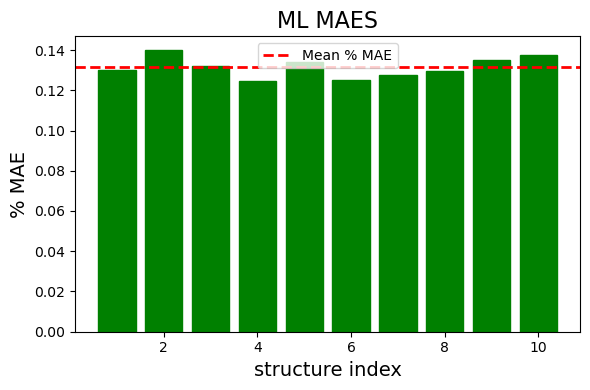

In [40]:
""" Load the prediction density errors and visualize them using barplots """

data_ml = np.loadtxt('ml_maes')
data_ml_x = [int(i) for i in data_ml.T[0]]
data_ml_y = data_ml.T[1]
mean_rmse = np.mean(data_ml_y)

plt.figure(figsize=(6, 4))  # Set the figure size
bars = plt.bar(data_ml_x, data_ml_y, color='green', edgecolor='green')

# Add title and labels with a custom font size
plt.title('ML MAES', fontsize=16)
plt.xlabel('structure index', fontsize=14)
plt.ylabel('% MAE', fontsize=14)
plt.axhline(y=mean_rmse, color='r', linestyle='--', linewidth=2, label='Mean % MAE')

plt.tight_layout()  # Adjust the layout to make room for the labels
plt.legend()
plt.show()

We can also compare energies' error.
The all the energy MAEs are very small.

In [ ]:
! python3 -m salted.aims.collect_energies

Mean absolute errors (eV/atom):
Electrostatic energy: 0.011857322500031842
XC energy: 0.003908863666661944
Total energy: 0.0002728900000079193


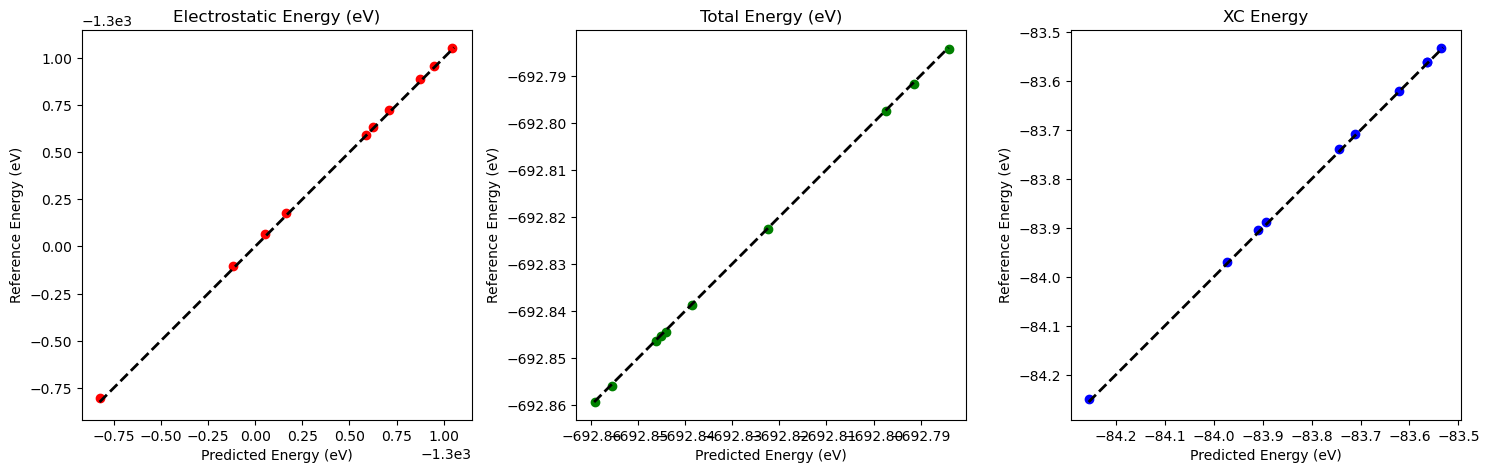

In [42]:
""" Visualization of predicted energies error """

pred_es = np.loadtxt('predict_reference_electrostatic_energy.dat')
pred_et = np.loadtxt('predict_reference_total_energy.dat')
pred_xc = np.loadtxt('predict_reference_xc_energy.dat')
x_pred_es, y_pred_es = pred_es.T
x_pred_et, y_pred_et = pred_et.T
x_pred_xc, y_pred_xc = pred_xc.T

# Create a figure and an array of subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
#fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Assuming the setup for your subplots and scatter plots is already done

# Add an x=y line to each subplot individually
# axes[0] for the first subplot
min_val_0, max_val_0 = min(x_pred_es.min(), y_pred_es.min()), max(x_pred_es.max(), y_pred_es.max())
axes[0].plot([min_val_0, max_val_0], [min_val_0, max_val_0], 'k--', linewidth=2)  # Black dashed line

# axes[1] for the second subplot
min_val_1, max_val_1 = min(x_pred_et.min(), y_pred_et.min()), max(x_pred_et.max(), y_pred_et.max())
axes[1].plot([min_val_1, max_val_1], [min_val_1, max_val_1], 'k--', linewidth=2)  # Black dashed line

## axes[2] for the third subplot
min_val_2, max_val_2 = min(x_pred_xc.min(), y_pred_xc.min()), max(x_pred_xc.max(), y_pred_xc.max())
axes[2].plot([min_val_2, max_val_2], [min_val_2, max_val_2], 'k--', linewidth=2)  # Black dashed line

# Plot data on each subplot
axes[0].scatter(x_pred_es, y_pred_es, color='r')
axes[1].scatter(x_pred_et, y_pred_et, color='g')
axes[2].scatter(x_pred_xc, y_pred_xc, color='b')

# Titles for each subplot
axes[0].set_title('Electrostatic Energy (eV)')
axes[1].set_title('Total Energy (eV)')
axes[2].set_title('XC Energy')

for ax in axes:
    ax.set_xlabel('Predicted Energy (eV)')
    ax.set_ylabel('Reference Energy (eV)')
    ax.set_aspect('equal', 'box')

# Adjust the plots to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()